In [1]:
from memoization import memoize_to_folder

In [2]:
from scapy.all import *
import sys
import numpy as np
import os

KEYLEN=8

@memoize_to_folder("memo/pcaps")
def read_pcap(out_dir):
    pcf = os.path.join(out_dir, 'tcpdump','tcpdump.pcap')
    if not os.path.exists(pcf):
        pcf = os.path.join(out_dir, 'gulp', 'gulp.pcap')
    if not os.path.exists(pcf):
        pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    print("Reading pcap file {}".format(pcf))
    
    gets = defaultdict(list)
    vals = defaultdict(list)
    
    def load_into_dict(pkt):
        try:
            spkt = pkt.load
        except AttributeError as e:
            return
        get_start = spkt.find('get ')
        if get_start >= 0:
            key = spkt[get_start+4:get_start+4+KEYLEN]
            gets[key].append(pkt.time)
            return
        val_start = spkt.find('VALUE ')
        if val_start >= 0:
            key = spkt[val_start+6:val_start+6+KEYLEN]
            vals[key].append(pkt.time)
        
    sniff(offline=pcf, prn=load_into_dict, store=0)
    print("Read pcap file")
    return gets, vals

def read_rate_file(out_dir):
    ratefile = os.path.join(out_dir, 'pktgen.log')
    with open(ratefile) as f:
        ratestr = f.read()
    if not ratestr.startswith('Rate: '):
        raise Exception("Could not read rate string")
    rate = int(ratestr.strip("Rate: "))
    return rate

def read_experiment(directory):
    print "Reading from directory {}".format(directory)
    return read_pcap(directory), read_rate_file(directory)

In [3]:
import itertools

def best_drop_tds(vtimes, gtimes, both_drops=0):
    vtimes = np.array(vtimes)
    gtimes = np.array(gtimes)
    lendiff = len(gtimes) - len(vtimes)
    maxlen = max(len(gtimes), len(vtimes))
    minlen = min(len(gtimes), len(vtimes))
    
    n_gdrops = max(-lendiff, 0)
    n_vdrops = max(lendiff, 0)
    
    if n_gdrops == 0 and n_vdrops == 0:
        tdiffs = vtimes - gtimes
        tds = []
        for td, gd in zip(tdiffs, gtimes):
            if not np.isnan(td) and td > 0:
                tds.append((gd, td))
        return tds        
    
    if n_gdrops != 0:
        print "Missing GET"
        
        drop_locs = []
        max_drop = 0
        
        for n_g in range(n_gdrops):
            v_cut = vtimes[: minlen + n_g + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(v_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_gtimes = gtimes[:]
                for drop_loc in this_drop_locs:
                    this_gtimes = np.insert(this_gtimes, drop_loc, np.nan)
                
                tdiffs = v_cut - this_gtimes
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        gdrops = gtimes[:]
        for drop_loc in drop_locs:
            gdrops = np.insert(gdrops, drop_loc, np.nan)
        tdiffs = vtimes - gdrops
        tds = []
        for td, gd in zip(tdiffs, gdrops):
            if not np.isnan(td):
                tds.append((gd, td))
        return tds

    if n_vdrops != 0:
        print "Missing VALUE"
        
        drop_locs = []
        max_drop = 0
        
        for n_v in range(n_vdrops):
            g_cut = gtimes[: minlen + n_v + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(g_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_vtimes = vtimes[:]
                for drop_loc in this_drop_locs:
                    this_vtimes = np.insert(this_vtimes, drop_loc, np.nan)
                
                tdiffs = this_vtimes - g_cut
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        vdrops = vtimes[:]
        for drop_loc in drop_locs:
            vdrops = np.insert(vdrops, drop_loc, np.nan)
        tdiffs = vdrops - gtimes
        tds = []
        for td, vd in zip(tdiffs, vdrops):
            if not np.isnan(td):
                tds.append((vd, td))
        return tds                

                
        

def get_tds(gets, values, threshold=None):
    print("Getting TDs")
    tds = []
    min_gtime = min(min(x) for x in gets.values())
    missing_values = []
    drops = 0
    for k, vtimes in values.items():
        if k not in gets:
            missing_values.extend(values[k])
            continue
        vtimes = np.array(vtimes)
        gtimes = np.array(gets[k])
        lendiff = len(gtimes) - len(vtimes)
        
        new_tds = best_drop_tds(vtimes, gtimes)
        tds.extend(new_tds)
        
        drops += abs(len(new_tds) - max(len(vtimes), len(gtimes)))
      
    print("Missing {} gets".format(len(missing_values)))
    print("{} drops".format(drops))
    print("{} tds".format(len(tds)))
    return np.array(tds)

@memoize_to_folder("memo/tds")
def experiment_tds(directory):
    (gets, vals), rate = read_experiment(directory)
    return get_tds(gets, vals), rate

In [4]:
best_drop_tds([2.5,4.5,],[2., 4., 5., 6., 7.])

Missing VALUE


[(2.5, 0.5), (4.5, 0.5)]

In [11]:
import glob
import time
import re
from multiprocessing import Pool as ThreadPool 

def experiment_tds_wrapper(arg):
    start = time.time()
    try:
        print("Running {}".format(arg))
        rtn = experiment_tds(arg)
        end = time.time()
        if rtn is None:
            rtn = experiment_tds(args, __recalculate=True)
        print("Completed {} in {}s".format(arg, end - start))
        return rtn, arg
    except Exception as e:
        print("Did not complete {}!!!! {}".format(ars, e))
        raise

def load_all_experiments(toptopdir='inputs', depth=1):
    d = toptopdir
    rec_dd = lambda : defaultdict(rec_dd)
    experiments = defaultdict(rec_dd)
    
    directories = glob.glob(os.path.join(toptopdir, '*'))
    for i in range(depth):
        new_directories = []
        for subdir in directories:
            new_directories.extend(glob.glob(os.path.join(subdir, '*')))
        directories = new_directories
        
    pool = ThreadPool(20)
    results = pool.map(experiment_tds_wrapper, directories)
    pool.close()
    pool.join()
        
    for (tds, rate), directory in results:
        split_dir = directory.split('/')
        keys = []
        for part in split_dir:
            if part not in toptopdir:
                for key in keys:
                    part = part.replace(key, '')
                    part = part.strip('_')
                keys.append(part)
        
        experiment = experiments
        for key in keys[:-1]:
            experiment = experiment[key]
        experiment[keys[-1]] = rate, tds
    
    return experiments
            
    #experiments[subsub][subdir] = load_all_experiments(d)

    #return dict(experiments)

In [12]:
booster_tds = experiment_tds('../output/no_pre_95_05/booster/no_pre_95_05_booster_0.25')

Loading from memo/tds/experiment_tds__directory-outputno_pre_95_05boosterno_pre_95_05_booster_025.pickle


In [13]:
experiments = load_all_experiments('../output', depth=2)

Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_0.75
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_3.25
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_0.25
Running ../output/pre_95_20/booster/pre_95_20_booster_1.25
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_2.25
Running ../output/pre_95_20/booster/pre_95_20_booster_0.75
Running ../output/pre_95_20/booster/pre_95_20_booster_2.25
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_1.25
Running ../output/pre_95_20/booster/pre_95_20_booster_1.75
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_1.75
Running ../output/pre_95_20/booster/pre_95_20_booster_2.75
Running ../output/no_pre_95_20/nobooster/no_pre_95_20_nobooster_3.25
Running ../output/pre_95_20/booster/pre_95_20_booster_0.25
Running ../output/pre_95_20/booster/pre_95_20_booster_3.25
Running ../output/pre_95_20/nobooster/pre_95_20_nobooster_2.75
Running ../output/no_pre_95_20/nobooster/no_pre_95_20_nobooster_1.75
Running 

Loading from memo/tds/experiment_tds__directory-outputno_pre_95_05noboosterno_pre_95_05_nobooster_275.pickle
Loading from memo/tds/experiment_tds__directory-outputno_pre_95_05boosterno_pre_95_05_booster_075.pickle
Loading from memo/tds/experiment_tds__directory-outputno_pre_95_20boosterno_pre_95_20_booster_075.pickle
Completed ../output/no_pre_95_05/nobooster/no_pre_95_05_nobooster_1.75 in 0.0316319465637s
Running ../output/no_pre_95_05/booster/no_pre_95_05_booster_2.25
Completed ../output/no_pre_95_20/booster/no_pre_95_20_booster_0.25 in 0.0443480014801s
Loading from memo/tds/experiment_tds__directory-outputno_pre_95_05boosterno_pre_95_05_booster_175.pickle
Completed ../output/no_pre_95_20/booster/no_pre_95_20_booster_1.25 in 0.0448830127716s
Loading from memo/tds/experiment_tds__directory-outputno_pre_95_05noboosterno_pre_95_05_nobooster_075.pickle
Completed ../output/no_pre_95_05/nobooster/no_pre_95_05_nobooster_2.75 in 0.03107213974s
Running ../output/no_pre_95_05/booster/no_pre_95

In [14]:
experiments

defaultdict(<function __main__.<lambda>>,
            {'no_pre_95_05': defaultdict(<function __main__.<lambda>>,
                         {'booster': defaultdict(<function __main__.<lambda>>,
                                      {'0.25': (109100,
                                        array([[1.54212227e+09, 9.05990601e-06],
                                               [1.54212227e+09, 1.00135803e-05],
                                               [1.54212227e+09, 3.88622284e-05],
                                               ...,
                                               [1.54212227e+09, 8.82148743e-06],
                                               [1.54212227e+09, 8.82148743e-06],
                                               [1.54212227e+09, 7.86781311e-06]])),
                                       '0.75': (327808,
                                        array([[1.54212248e+09, 8.82148743e-06],
                                               [1.54212248e+09, 1.09672546

In [15]:
experiments.keys()

['pre_95_20', 'no_pre_95_05', 'no_pre_95_20', 'pre_95_05']

In [16]:
experiments['pre_95_20'].keys()

['nobooster', 'booster']

In [17]:
experiments['pre_95_20']['booster'].keys()

['0.25', '2.75', '1.75', '3.25', '0.75', '1.25', '2.25']

In [37]:
sorted([x[0] for x in experiments['pre_95_20']['booster'].values()])

[107176, 321692, 527592, 743964, 957480, 1167800, 1381044]

In [18]:
def filter_tds(tds, percentile):
    return tds[tds[:,1] < np.percentile(tds[:,1], percentile)]
    

In [57]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_timeseries(tds, label):
    times, diffs = filter_tds(tds, 90).T
    print len(diffs)
    scaled_times = (times - min(times)) / (max(times) - min(times))
    plt.plot(scaled_times, diffs * 1000000, '.', markersize=1, label="{}k ({} drops)".format(label / 1000, 50000 - len(tds)))
    
def plot_histogram(tds, label):
    times, diffs = filter_tds(tds, 90).T
    plt.hist(diffs[diffs < .0002], 50, alpha=.35, label=["{}k ({} drops)".format(label / 1000, 45000 - len(tds))])

<IPython.core.display.Javascript object>


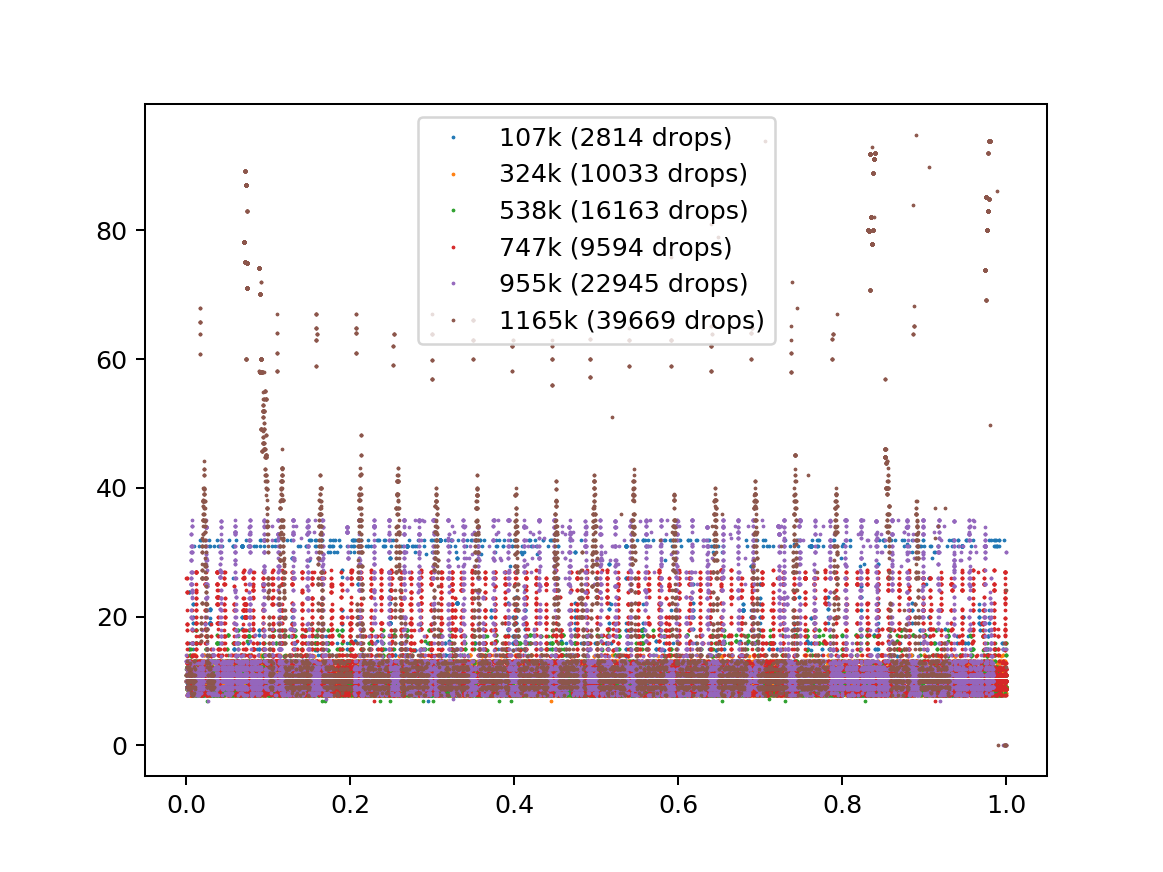

42412
35962
30395
36344
24114
9290


In [58]:
booster = experiments['pre_95_05']['booster']

plt.figure()
plot_timeseries(booster['0.25'][1], booster['0.25'][0])
plot_timeseries(booster['0.75'][1], booster['0.75'][0])
plot_timeseries(booster['1.25'][1], booster['1.25'][0])
plot_timeseries(booster['1.75'][1], booster['1.75'][0])
plot_timeseries(booster['2.25'][1], booster['2.25'][0])
plot_timeseries(booster['2.75'][1], booster['2.75'][0])
plt.legend()

<IPython.core.display.Javascript object>


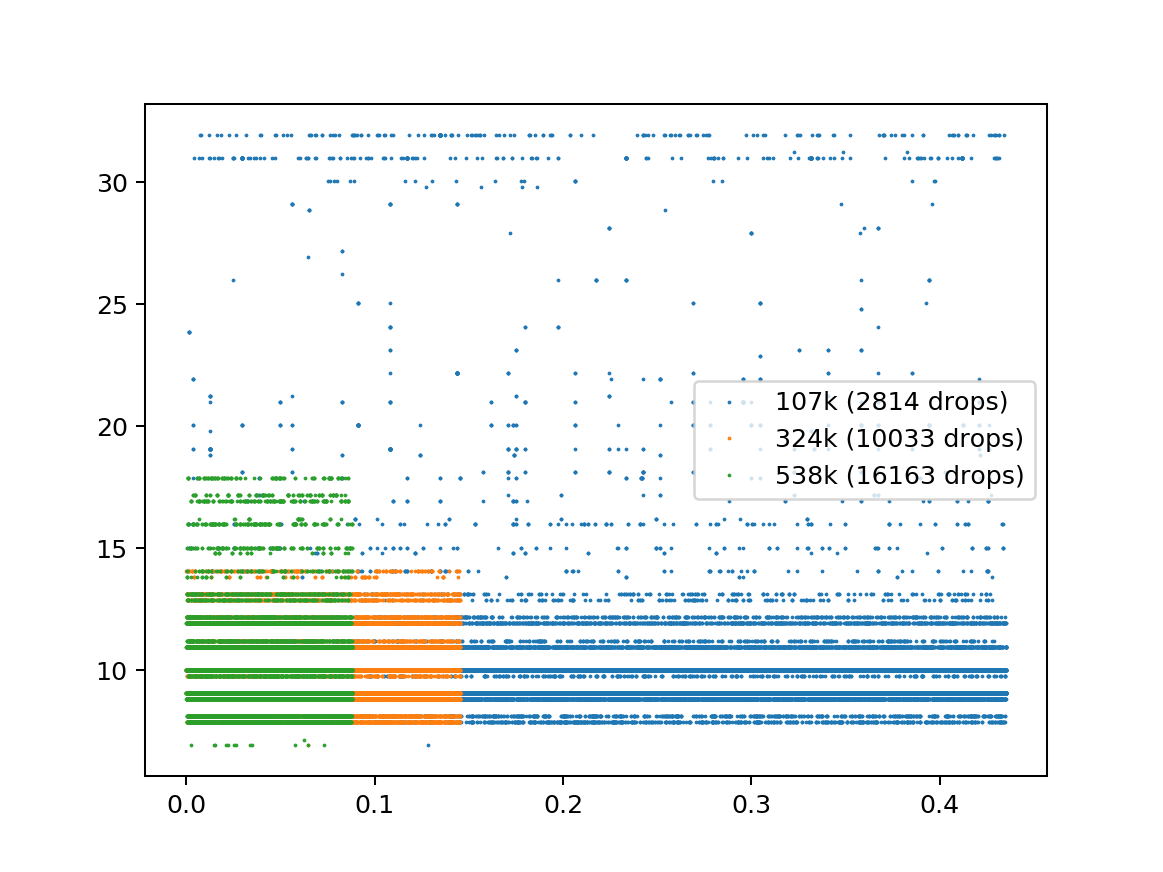

42412
35962
30395


<IPython.core.display.Javascript object>


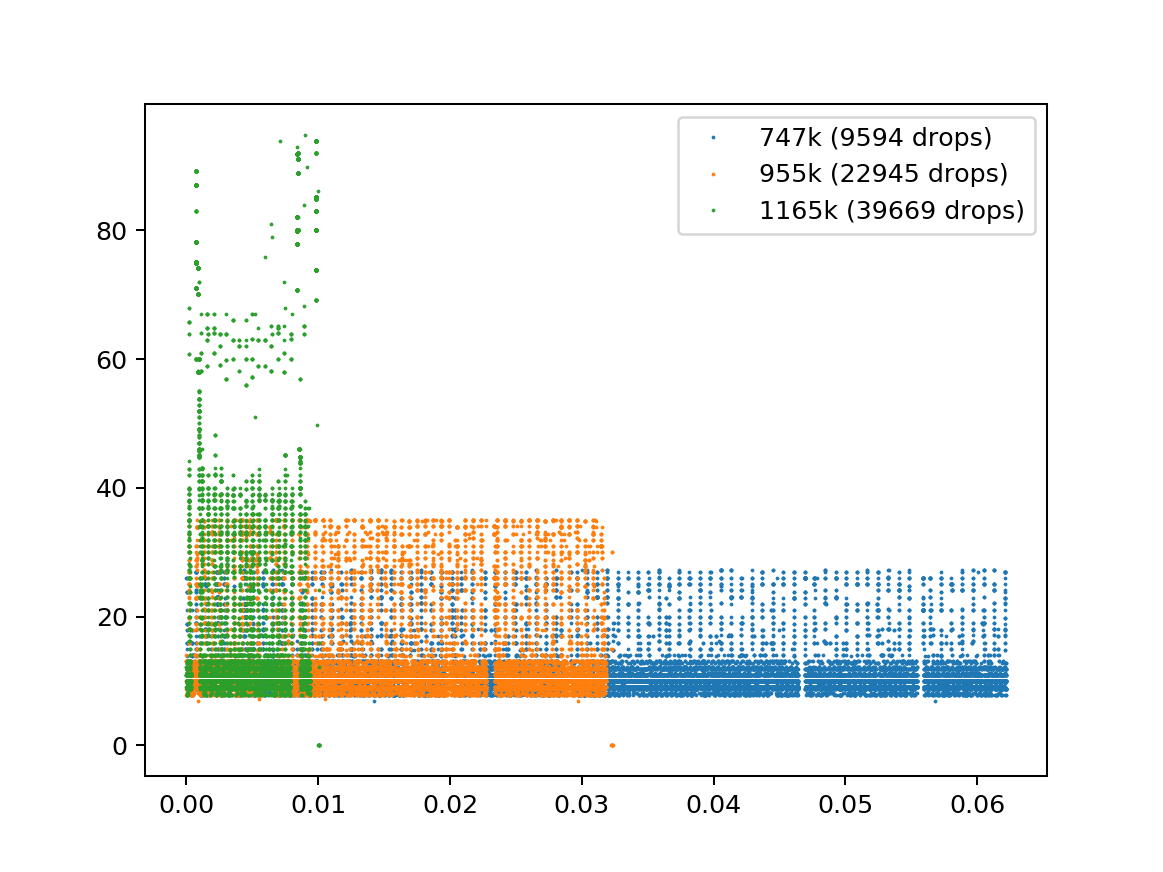

36344
24114
9290


<IPython.core.display.Javascript object>


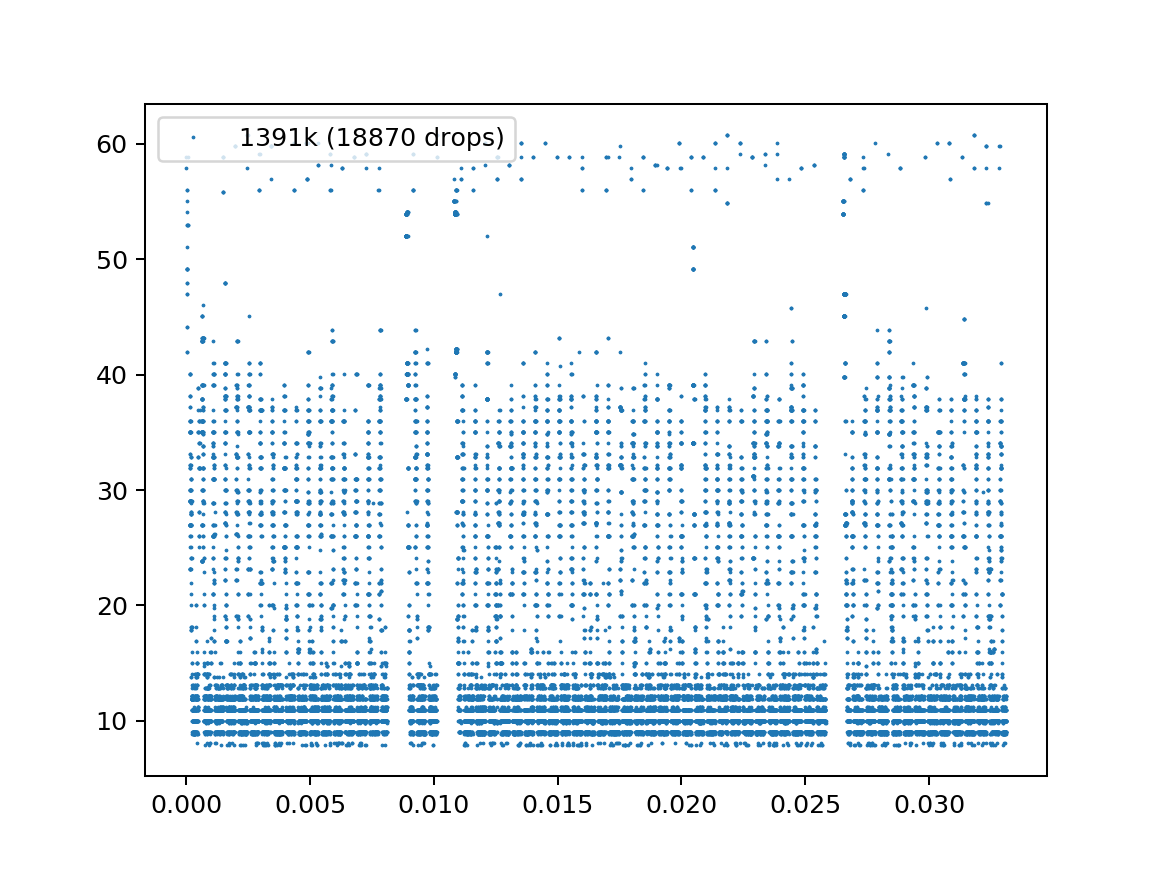

27971


In [55]:
for i, (k, v) in enumerate(sorted(experiments['pre_95_05']['booster'].items())):
    if i % 3 == 0:
        plt.figure()
    plot_timeseries(v[1], v[0])
    plt.legend()

<IPython.core.display.Javascript object>


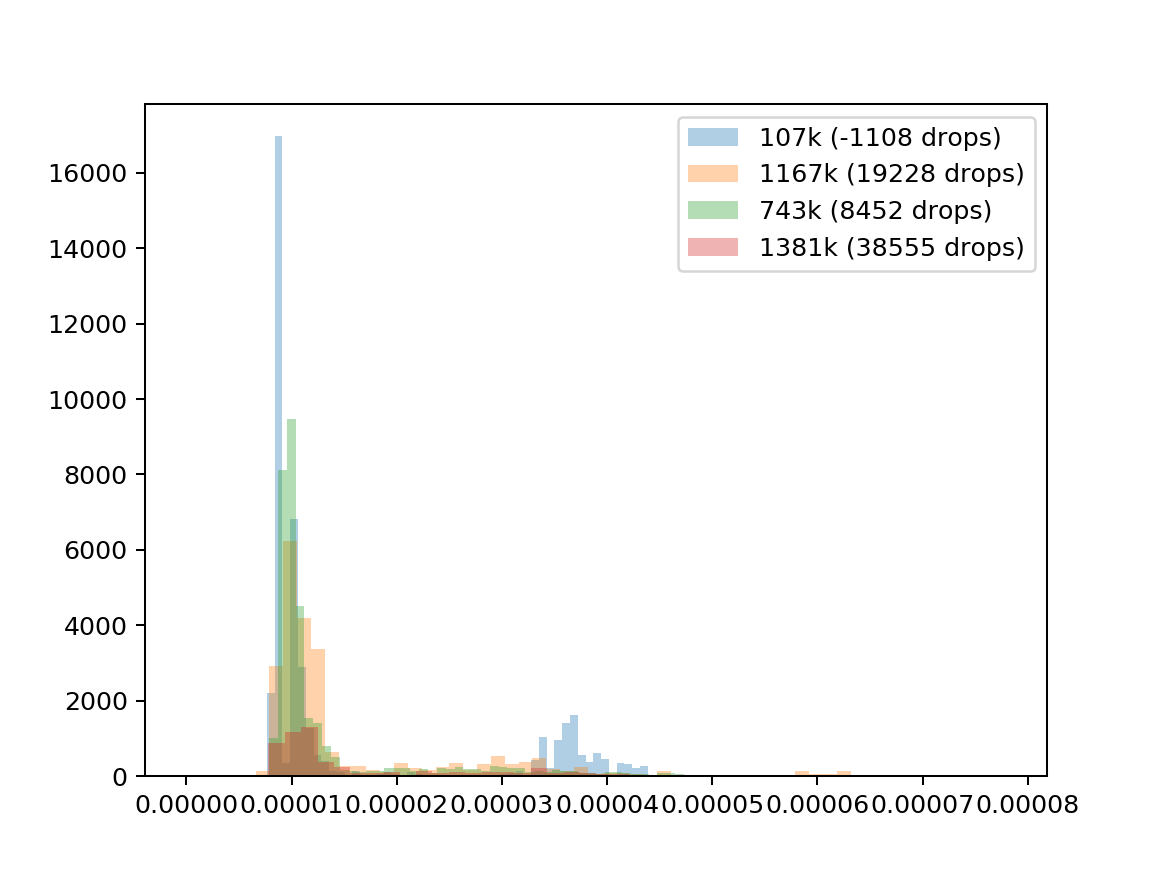

<IPython.core.display.Javascript object>


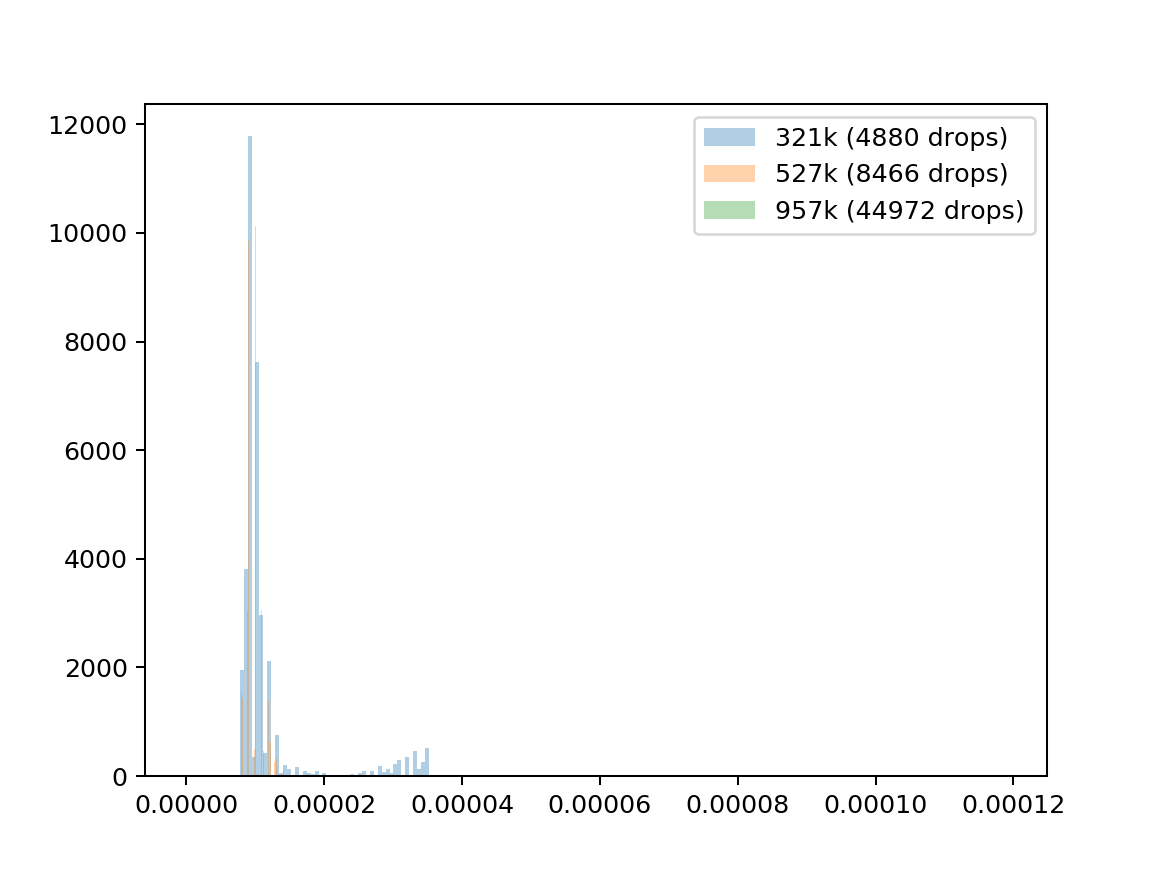

In [42]:
for i, tds in enumerate(experiments['pre_95_20']['booster'].values()):
    if i % 4 == 0:
        plt.figure()
    plot_histogram(tds[1], tds[0])
    plt.legend()

<IPython.core.display.Javascript object>


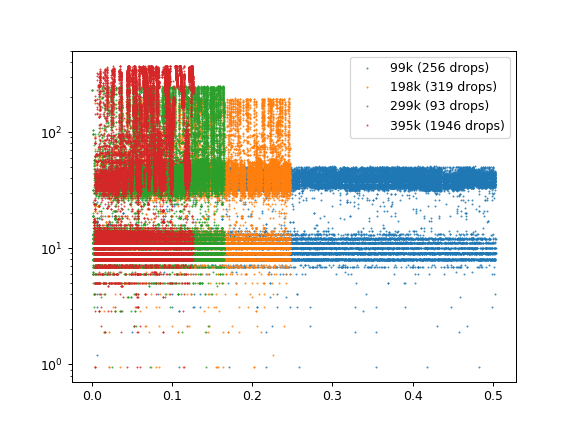

40201
40209
40411
38739


<IPython.core.display.Javascript object>


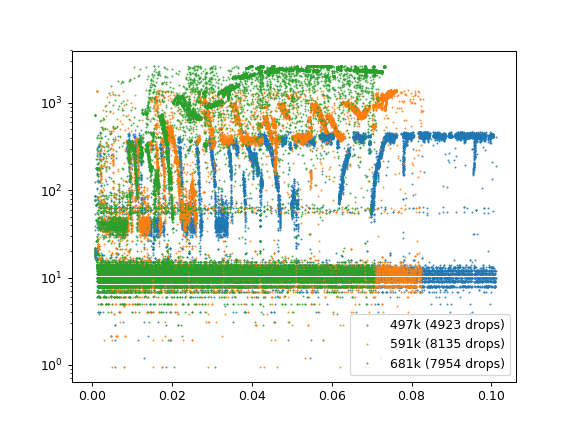

36060
33178
33333


In [25]:
tdss = [tds05, tds10, tds15, tds20, tds25, tds30, tds35]

for i, tds in enumerate(tdss):
    if i % 4 == 0:
        plt.figure()
    plot_timeseries(tds[0], tds[1])
    plt.legend()
plt.legend()

<IPython.core.display.Javascript object>


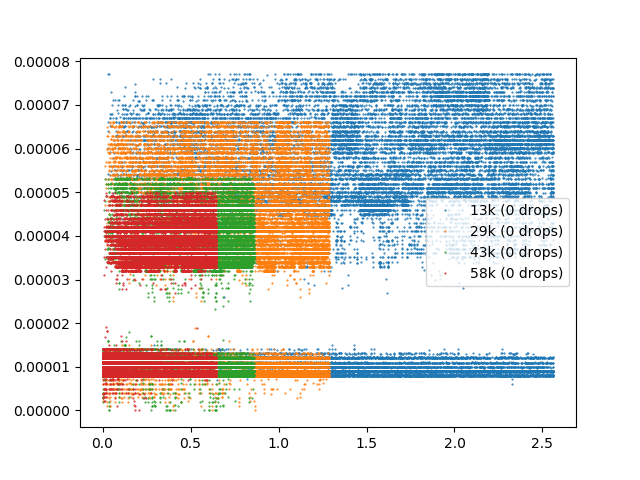

40413
40488
40450
40494


<IPython.core.display.Javascript object>


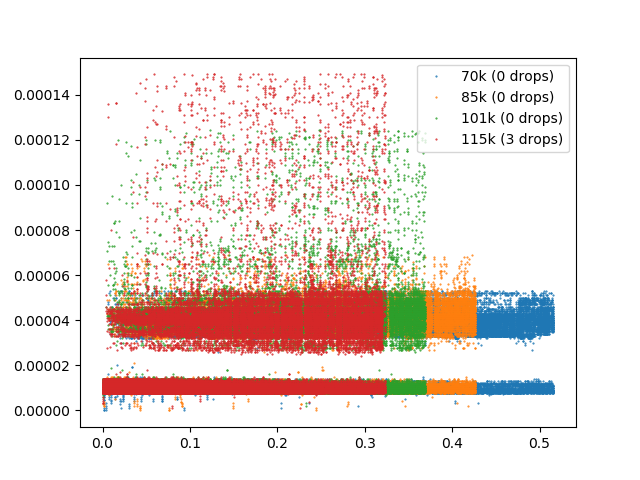

40467
40498
40500
40490


<IPython.core.display.Javascript object>


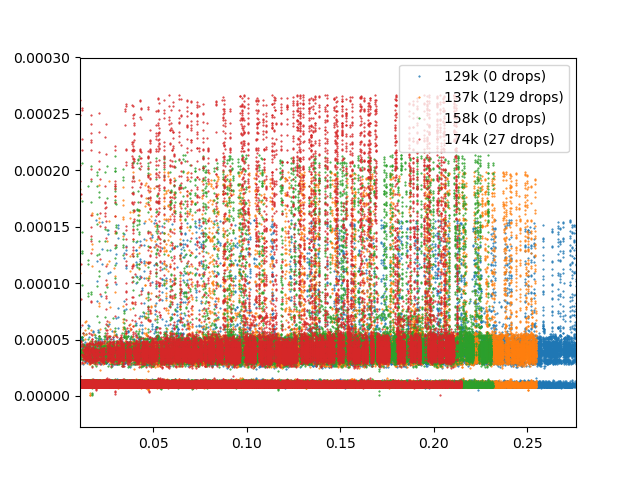

40498
40377
40494
40475


<IPython.core.display.Javascript object>


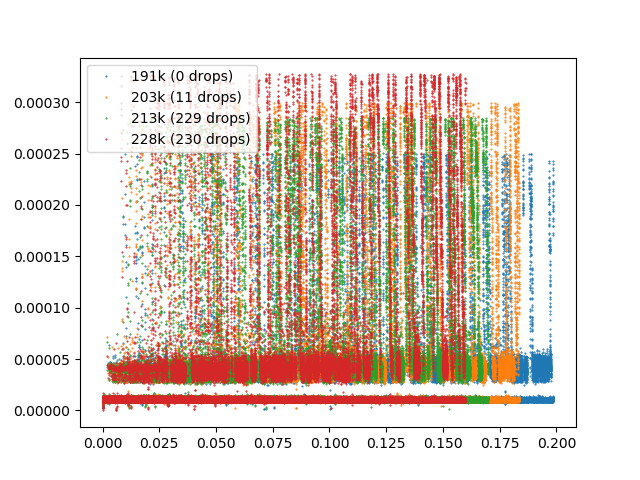

40484
40488
40283
40288


<IPython.core.display.Javascript object>


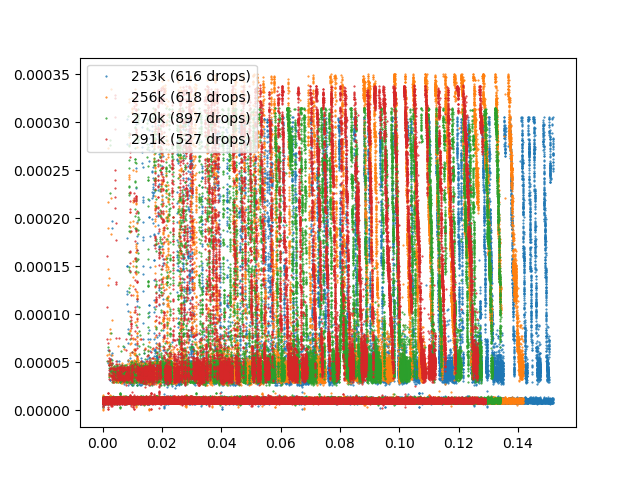

39942
39924
39683
39986


<IPython.core.display.Javascript object>


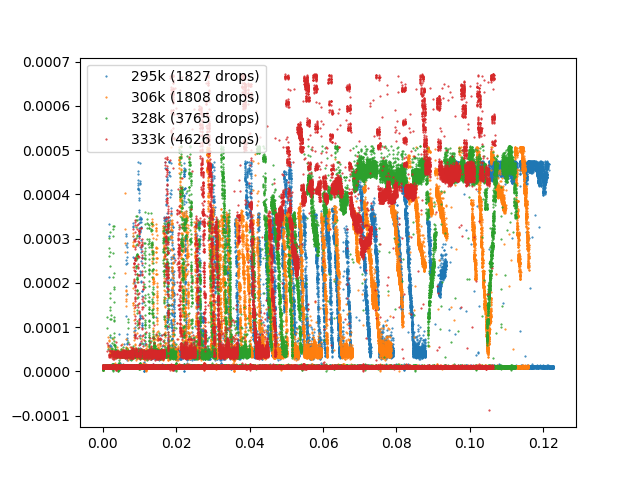

38839
38864
37110
36336


<IPython.core.display.Javascript object>


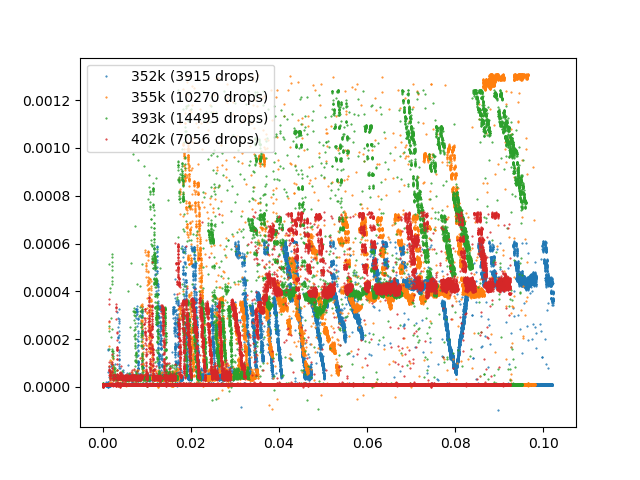

36974
31255
27454
34137


<IPython.core.display.Javascript object>


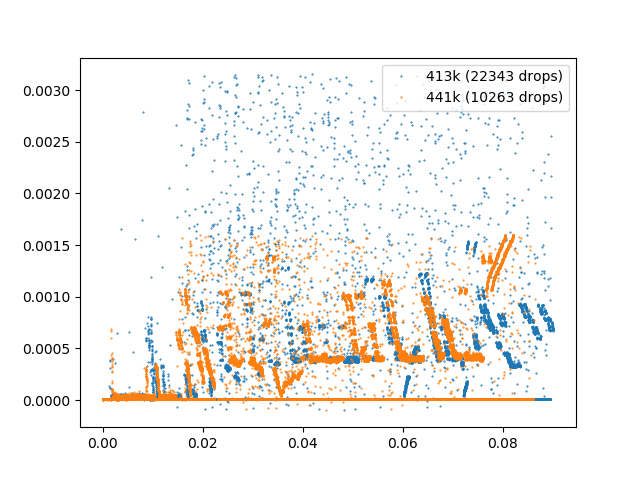

20391
31263


<IPython.core.display.Javascript object>


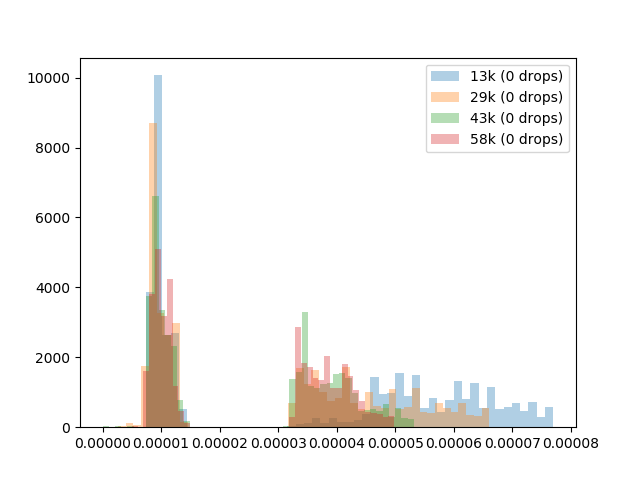

<IPython.core.display.Javascript object>


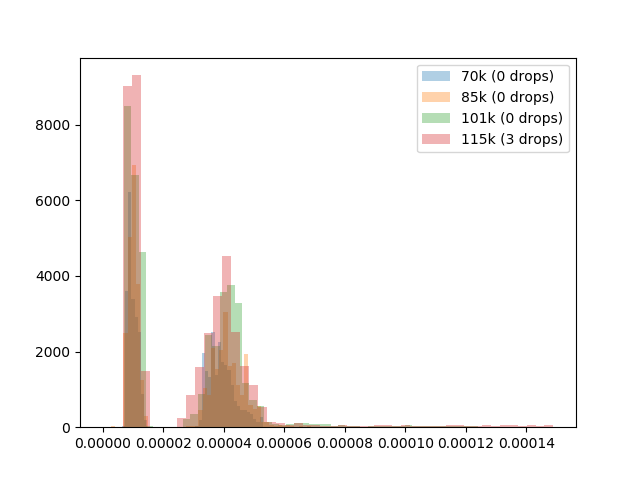

<IPython.core.display.Javascript object>


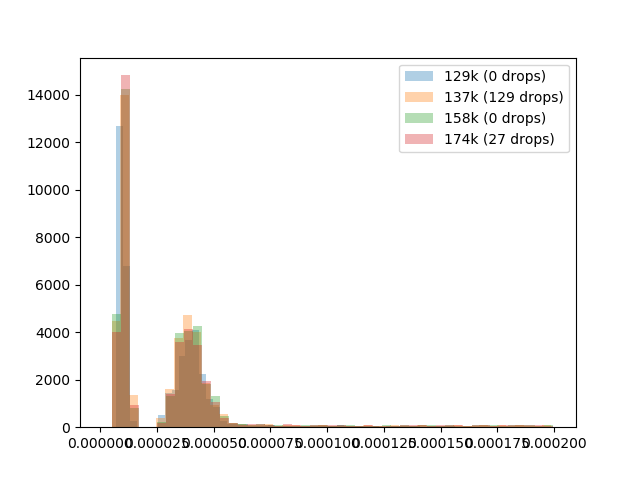

<IPython.core.display.Javascript object>


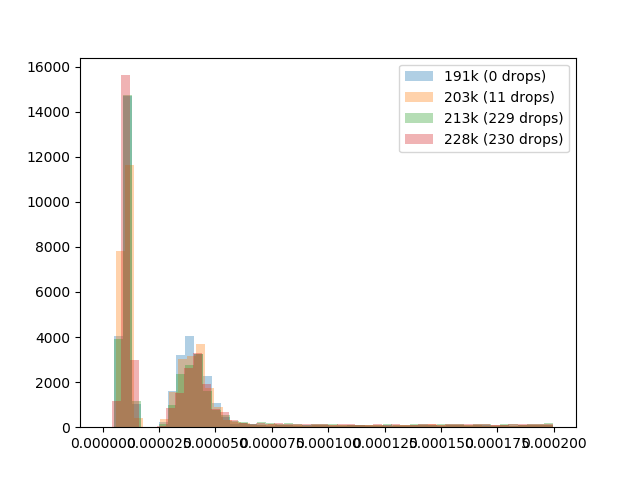

<IPython.core.display.Javascript object>


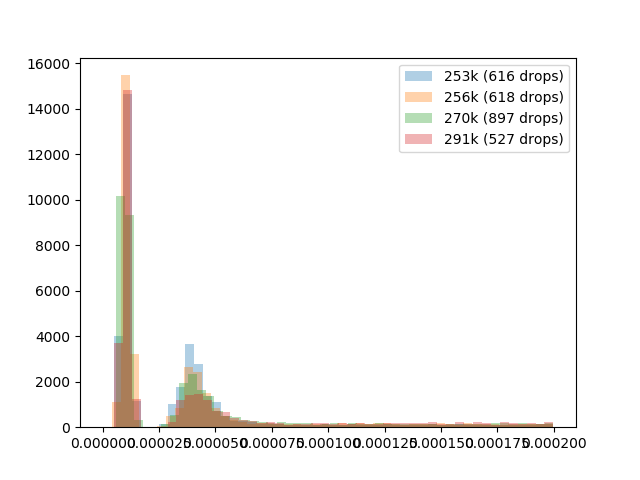

<IPython.core.display.Javascript object>


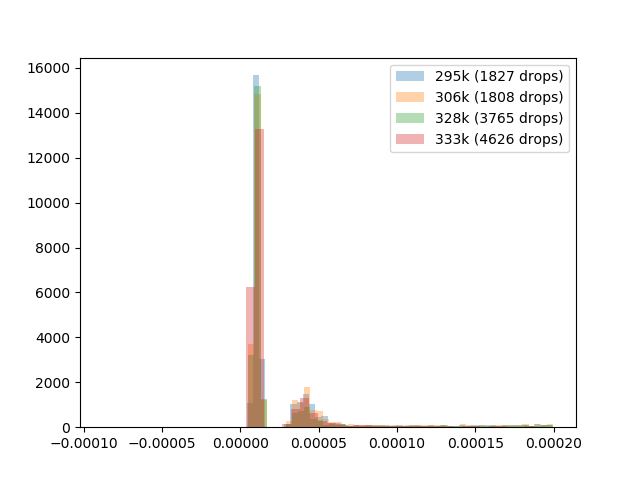

<IPython.core.display.Javascript object>


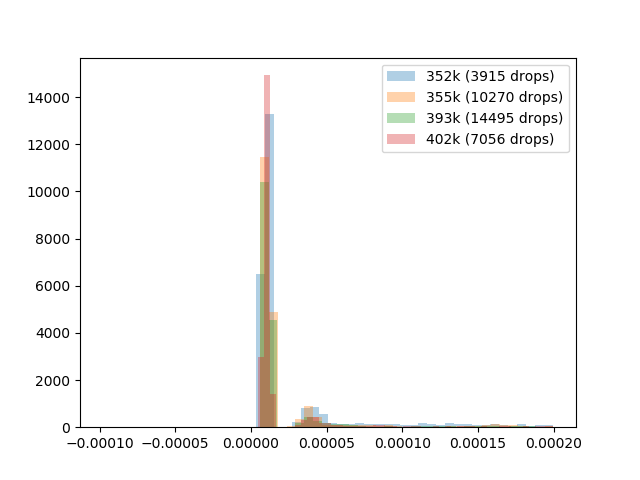

<IPython.core.display.Javascript object>


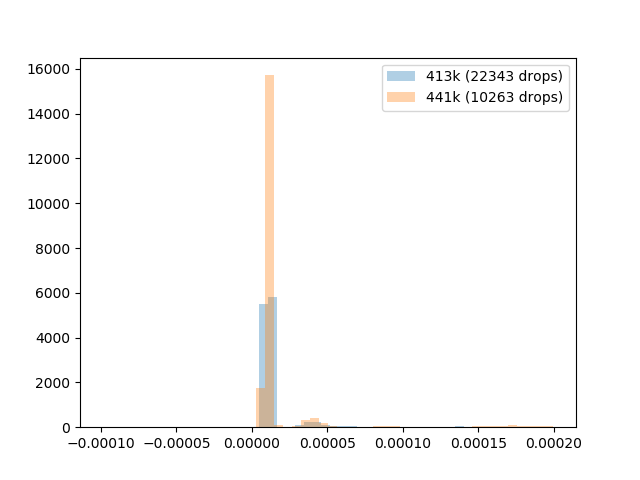

In [72]:
o1 = experiments['booster']['output_4']
for i, key in enumerate(sorted(o1.keys())):
    if i % 4 == 0:
        plt.figure()
    plot_timeseries(o1[key], key)
    plt.legend()

for i, key in enumerate(sorted(o1.keys())):
    if i % 4 == 0:
        plt.figure()
    plot_histogram(o1[key], key)
    plt.legend()

In [48]:
cols = ["#9c2b2a",
"#3d8500",
"#0086b3"]
def plot_experiments(experiments, threshold=25e-6):
    keys, values = zip(*(sorted(experiments.items())))
#    keys, values = zip(*((k, v) for k, v in zip(keys, values) if k < 270000))
    sub, sup = [], []
    no = []
    for val in values:
        if threshold is not None:
            low = val[val[:,1] < threshold,1]
            high = val[val[:,1] > threshold,1]
            print('HIT RATE: ', float(len(low)) / float(len(high) + len(low)))
            sub.append([np.percentile(low, x) * 1000000 for x in (10, 50, 90)])
            sup.append([np.percentile(high, x) * 1000000 for x in (10, 50, 90)])
            print(float(len(high)) / len(low))
            #_, lowdiffs = filter_tds(low, 90).T
            #_, hidiffs = filter_tds(high, 90).T
            #sub.append(lowdiffs.mean() * 1000)
            #sup.append(hidiffs.mean() * 1000)
        else:
            no.append([np.percentile(val[:,1], x) * 1000000 for x in (10, 50, 90)])
    if no:
        low, med, high = zip(*no)
        plt.fill_between(keys, low, high, label='No Booster', alpha=.2, color=cols[2])
        plt.plot(keys, med, '.-', color=cols[2])
        #print('no', no)
    if sub:
        #print(sub)
        low, med, high = zip(*sub)
        plt.fill_between(keys, low, high, label='Booster Hits', color=cols[0], alpha=.5)
        plt.plot(keys, med, '.-', color=cols[0])
    if sup:
        low, med, high = zip(*sup)
        plt.fill_between(keys, low, high, label='Booster Misses', alpha=.2, color=cols[1])
        plt.plot(keys, med, '.-', color=cols[1])
        #print(sup)

<IPython.core.display.Javascript object>


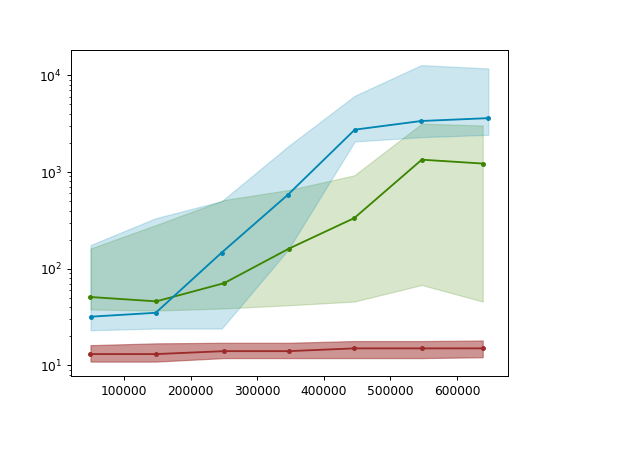

('HIT RATE: ', 0.4287111111111111)
1.33257308729
('HIT RATE: ', 0.42077777777777775)
1.37655135992
('HIT RATE: ', 0.3577199848503977)
1.79548261867
('HIT RATE: ', 0.4003385333272336)
1.49788595589
('HIT RATE: ', 0.39775758291042135)
1.51409411904
('HIT RATE: ', 0.37990291803827486)
1.63225143193
('HIT RATE: ', 0.3609600346348459)
1.7703898051


In [49]:
plt.figure()

plot_experiments(bounce_boosters)
plot_experiments(bounce_noboosters, None)
plt.yscale('log')

<IPython.core.display.Javascript object>


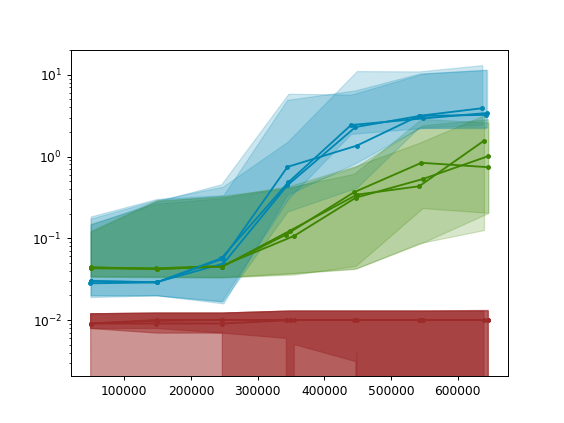

('HIT RATE: ', 0.4494)
1.22518914108
('HIT RATE: ', 0.4507553812558492)
1.21849819566
('HIT RATE: ', 0.4531896897119708)
1.20658153242
('HIT RATE: ', 0.45123537061118335)
1.21613832853
('HIT RATE: ', 0.4527214304986632)
1.2088638457
('HIT RATE: ', 0.4739533562333738)
1.10991226636
('HIT RATE: ', 0.5107031845639552)
0.958084519982
('HIT RATE: ', 0.45224444444444445)
1.21119355314
('HIT RATE: ', 0.4498875281179705)
1.22277777778
('HIT RATE: ', 0.42929740314233766)
1.32938748914
('HIT RATE: ', 0.4433323385597209)
1.25564415907
('HIT RATE: ', 0.4631475770398527)
1.1591390079
('HIT RATE: ', 0.4959635910494663)
1.01627703736
('HIT RATE: ', 0.4960780509437623)
1.01581182255
('HIT RATE: ', 0.4507555555555556)
1.2184973378
('HIT RATE: ', 0.44895555555555555)
1.22739197149
('HIT RATE: ', 0.45297833533520176)
1.20761109747
('HIT RATE: ', 0.4393140768852344)
1.27627579587
('HIT RATE: ', 0.45346520563540627)
1.20524085988
('HIT RATE: ', 0.4864522597155898)
1.0557001844
('HIT RATE: ', 0.485558372836

In [26]:
plt.figure()
plot_experiments(boosters1)
plot_experiments(noboosters1, None)

plot_experiments(boosters2)
plot_experiments(noboosters2, None)

plot_experiments(boosters3)
plot_experiments(noboosters3, None)

plt.yscale('log')

<IPython.core.display.Javascript object>


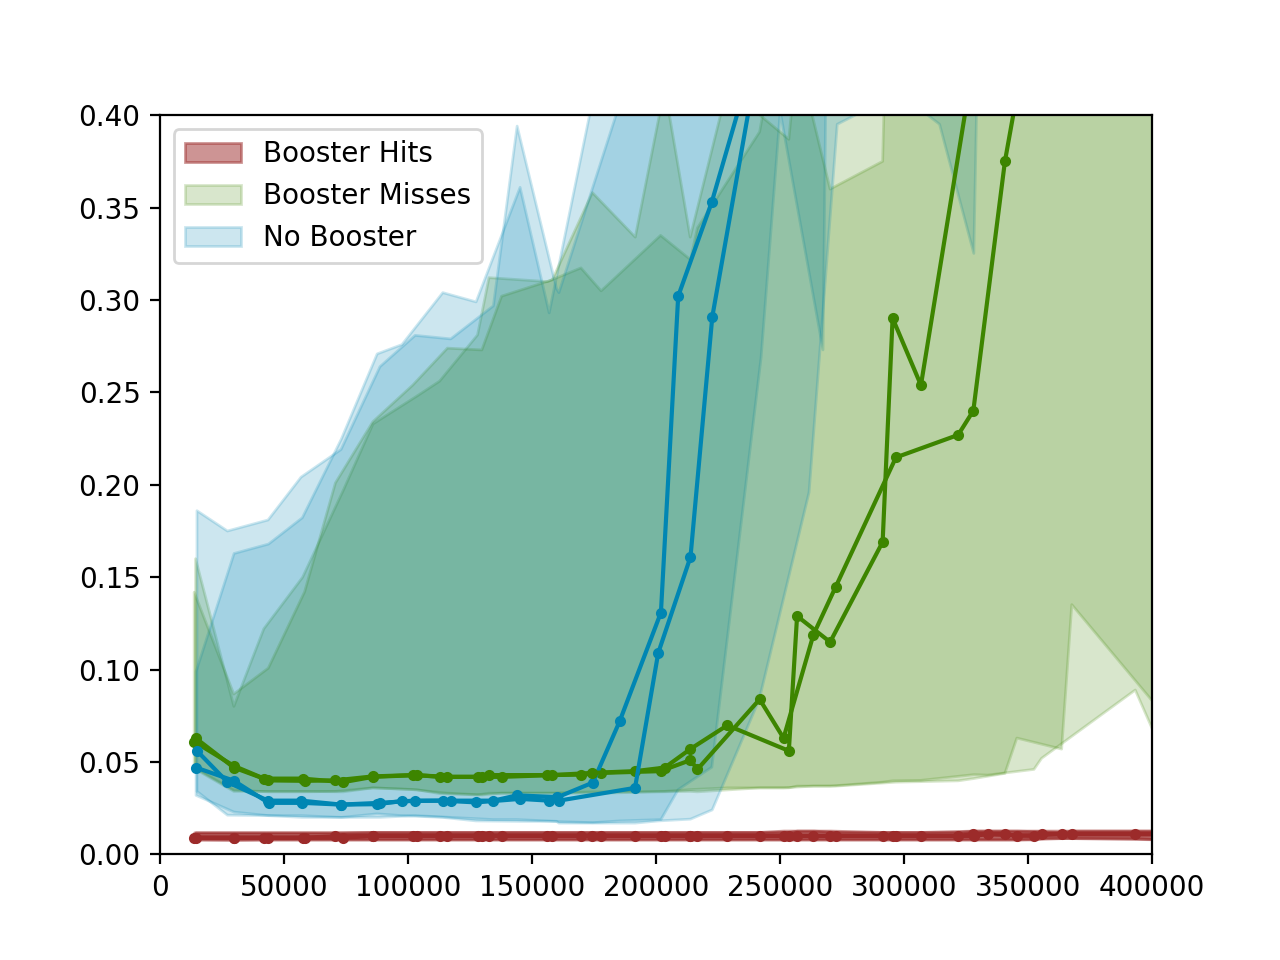

('HIT RATE: ', 0.44)
1.27272727273
('HIT RATE: ', 0.44006666666666666)
1.27238297228
('HIT RATE: ', 0.4401111111111111)
1.27215349659
('HIT RATE: ', 0.44006666666666666)
1.27238297228
('HIT RATE: ', 0.4401555555555556)
1.27192406725
('HIT RATE: ', 0.43993333333333334)
1.27307167753
('HIT RATE: ', 0.44026666666666664)
1.27135069655
('HIT RATE: ', 0.4398222222222222)
1.27364591754
('HIT RATE: ', 0.4398222222222222)
1.27364591754
('HIT RATE: ', 0.4406775893115177)
1.26923270948
('HIT RATE: ', 0.44127195908383365)
1.26617617416
('HIT RATE: ', 0.4407119467153772)
1.26905580267
('HIT RATE: ', 0.44082912617040676)
1.26845265123
('HIT RATE: ', 0.4402209009731222)
1.27158682786
('HIT RATE: ', 0.44164565716963033)
1.26425865117
('HIT RATE: ', 0.4449483610237988)
1.24745181148
('HIT RATE: ', 0.44365470852017935)
1.2540051549
('HIT RATE: ', 0.4448055586686092)
1.24817334341
('HIT RATE: ', 0.4452289691345572)
1.24603534209
('HIT RATE: ', 0.4499159969123189)
1.22263712974
('HIT RATE: ', 0.4561242515

(0, 400000)

In [83]:
plt.figure()
plot_experiments(experiments['booster']['output_3'])
plot_experiments(experiments['nobooster']['output_3'], None)
plt.legend()
plot_experiments(experiments['booster']['output_4'])
plot_experiments(experiments['nobooster']['output_4'], None)

plt.ylim([0, .4])
plt.xlim([0, 400000])

In [56]:
cols = ["#9c2b2a",
"#3d8500",
"#0086b3"]
def recreate_plot(experiments, threshold=.00002):
    keys, values = zip(*(sorted(experiments.items())))
#    keys, values = zip(*((k, v) for k, v in zip(keys, values) if k < 270000))
    sub, sup = [], []
    no = []
    for val in values:
        if threshold is not None:
            low = val[val[:,1] < threshold,:]
            high = val[val[:,1] > threshold,:]
            
            _, low = filter_tds(low, 95).T
            _, high = filter_tds(high, 95).T
            
            sub.append(np.mean(low) * 1000000)
            sup.append(np.mean(high) * 1000000)
            print(float(len(high)) / len(low))
            #_, lowdiffs = filter_tds(low, 90).T
            #_, hidiffs = filter_tds(high, 90).T
            #sub.append(lowdiffs.mean() * 1000)
            #sup.append(hidiffs.mean() * 1000)
        else:
            _, non = filter_tds(val, 95).T
            no.append(np.mean(non) * 1000000)
    if no:
        plt.plot(keys, no, '.-', color=cols[2], label="No Booster")
        #print('no', no)
    if sub:
        #print(sub)
        plt.plot(keys, sub, '.-', color=cols[0], label="Booster Hits")
    if sup:
        plt.plot(keys, sup, '.-', color=cols[1], label="Booster misses")
        #print(sup)

<IPython.core.display.Javascript object>


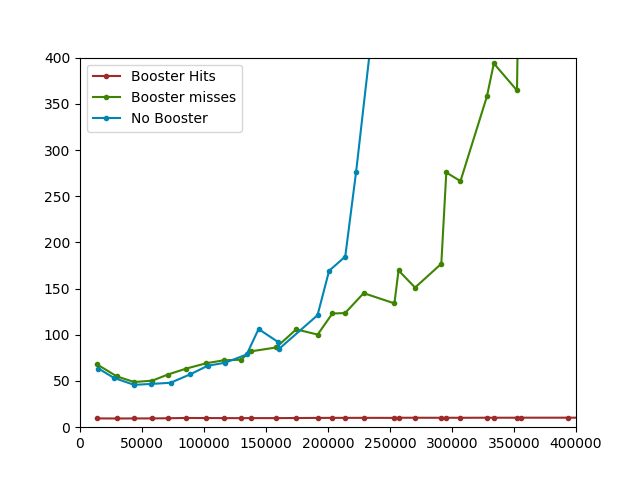

1.31878787879
1.31855238515
1.32268405925
1.32767797738
1.27738044406
1.30676724609
1.30505050505
1.30264879006
1.29288567419
1.28806495264
1.29505004057
1.30476086482
1.27470713525
1.27523621417
1.27037890562
1.27193311539
1.24850010714
1.25812537056
1.2445570166
1.2646852581
1.19032050595
1.20007550019
1.11059232314
1.08097897503
1.09944541105
1.13481607096
1.0608302212
0.986549087459
1.0306766055
1.00337962394


(0, 400000)

In [73]:
plt.figure()
recreate_plot(experiments['booster']['output_4'])
recreate_plot(experiments['nobooster']['output_4'], None)
plt.legend()

plt.ylim([0, 400])
plt.xlim([0, 400000])

In [ ]:
filter_tds